# Combining data from DEA and Microsoft Planetary Computer <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatability:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.dea.ga.gov.au/ga_ls_landcover_class_cyear_2),
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3),
[esa-worldcover](https://planetarycomputer.microsoft.com/dataset/esa-worldcover),
[landsat-c2-l2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#overview)






## Background
Similar to Digital Earth Australia (DEA), [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/) contains a multi-petabyte catalog of satellite and environmental data, provided in analysis ready data formats hosted in the cloud.
This data is accompanied by detailed [SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/en) metadata, which makes it possible to search and discover data from specific products, time periods and locations of interest.

Using tools from Open Data Cube (`odc-stac`), we can search for Planetary Computer data, and load it directly into our Jupyter notebook for further analysis.
This opens up the potential to combine a wide variety of data from Microsoft Planetary Computer with products from DEA, allowing us to obtain richer insights into the Australian environment.


## Description
This notebook demonstrates how to load Microsoft Planetary Computer data into a Jupyter Notebook:

1. Use `pystac_client` to search for ESA WorldCover land cover data for a study area and time period
2. Load ESA WorldCover data into the notebook using the [odc-stac](https://odc-stac.readthedocs.io/en/latest/?badge=latest) Python library
3. Compare these outputs against DEA's Land Cover product
4. Load a time series of USGS Landsat surface temperature from Planetary Computer
5. Combine this data with DEA's Landsat ARD

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
import pystac_client
import planetary_computer
import matplotlib.pyplot as plt

import datacube
import odc.stac
import odc.geo.xr
from odc.geo.geom import BoundingBox

sys.path.insert(1, "../Tools/")
from dea_tools.datahandling import load_ard
from dea_tools.plotting import display_map

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app="Planetary_computer")

### Analysis parameters

In this notebook, we will first demonstrate how to load data from the European Space Agency's **ESA WorldCover** land cover dataset using Microsoft Planetary Computer:

> The European Space Agency (ESA) WorldCover product provides global land cover maps for the years 2020 and 2021 at 10 meter resolution based on the combination of Sentinel-1 radar data and Sentinel-2 imagery. The discrete classification maps provide 11 classes defined using the Land Cover Classification System (LCCS) developed by the United Nations (UN) Food and Agriculture Organization (FAO). The map images are stored in cloud-optimized GeoTIFF format ([dataset listing](https://planetarycomputer.microsoft.com/dataset/esa-worldcover))

First we set some spatial and temporal extents to load data for:

* `x`: The longitude range to analyse (e.g. `(122.10, 122.48)`).
* `y`: The latitude range to analyse (e.g. `(-17.91, -18.28)`).
* `time`: The date range to analyse (e.g. `("2020-01", "2020-02")`).

<div class="alert alert-block alert-info">

<b>Tip:</b> Keep these extents as small as possible for reasonable loading times!

</div> 


In [3]:
# Define the area of interest
x = (122.10, 122.48)
y = (-17.91, -18.28)

# Set the range of dates for the analysis
time = ("2020-01", "2020-02")

View the selected location:

In [4]:
display_map(x=x, y=y)

## Searching for data on Microsoft Planetary Computer

### Open a `pystac` client
The first step in searching for data is to open a `pystac` client that points to Microsoft Planetary Computer's data catalogue.
This is equivalent to connecting to DEA's datacube database by running `dc = datacube.Datacube()` at the top of our notebooks.

Microsoft Planetary Computer products [can be browsed here](https://planetarycomputer.microsoft.com/catalog). 
Note that some Planetary Computer products aren't currently set up to allow accessed using the code examples below, or may require additional permissions or authentication.

In [5]:
# Open a client pointing to the Microsoft Planetary Computer data catalogue
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Searching for STAC items to load

Now that we have connected to Microsoft Planetary Computer, we can use our spatial and temporal extents to search for data from the **"esa-worldcover"** product.

Running this cell will search Planetary Computer's STAC metadata catalogue for data that matches our query, and return these as a list of STAC "items" ([roughly equivalent to an individual Open Data Cube "dataset"](https://odc-stac.readthedocs.io/en/latest/stac-vs-odc.html)).

In [6]:
# Convert data-cube style queries into something readable by `pystac_client`
bbox = BoundingBox.from_xy(x, y)
time_range = "/".join(time)

# Search for STAC items from "esa-worldcover" product
search = catalog.search(
    collections="esa-worldcover",
    bbox=bbox,
    datetime=time_range,
)

# Check how many items were returned
items = search.item_collection()
print(f"Found {len(items)} STAC items")

Found 2 STAC items


## Loading data using `odc-stac`

Once we have found some data, we can load it into our notebook using the [odc-stac](https://odc-stac.readthedocs.io/en/latest/?badge=latest) Python library.
The `odc.stac.load` function works similarly to `dc.load`, allowing us to load one or more bands of data into an `xarray.Dataset()`.

Here we will load ESA WorldCover data for our study area into Australian Albers 25 m pixels, matching the projection system and CRS used by DEA's existing DEA Land Cover product.

> **Note:** The `odc.stac.load` function uses slightly different terminology to `dc.load`, for example: "bands" vs "measurements", "groupby" vs "group_by", "chunks" vs "dask_chunks".

In [7]:
# Load ESA WorldCover data with odc-stac
ds_worldcover = odc.stac.load(
    items,
    bbox=bbox,
    bands=["map"],
    crs="EPSG:3577",
    resolution=25,
)

# Inspect outputs
ds_worldcover

<xarray.Dataset>
Dimensions:      (y: 1756, x: 1730, time: 1)
Coordinates:
  * y            (y) float64 -1.95e+06 -1.95e+06 ... -1.994e+06 -1.994e+06
  * x            (x) float64 -1.048e+06 -1.048e+06 ... -1.005e+06 -1.005e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2020-01-01
Data variables:
    map          (time, y, x) uint8 80 80 80 80 80 80 80 ... 20 20 20 20 20 20

Plot our data to verify it loaded OK:

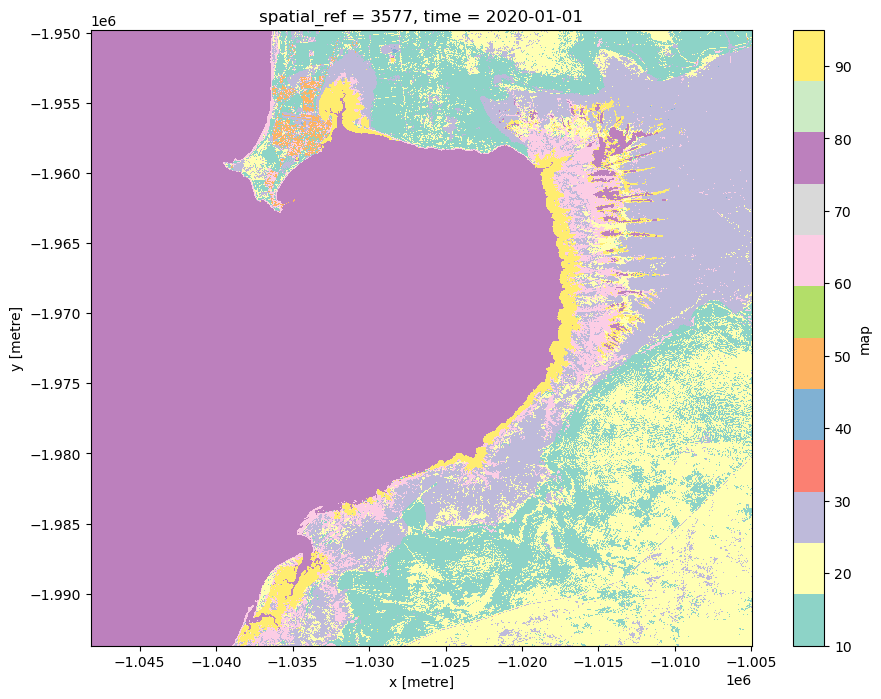

In [8]:
ds_worldcover["map"].plot(size=8, cmap="Set3")

### Load data from DEA for comparison
Now we can load data from DEA to compare against the ESA World Cover data loaded from Planetary Computer.
In this example, we will load data from the [DEA Land Cover product](../DEA_products/DEA_Land_Cover.ipynb):

In [9]:
# Load DEA Land Cover data from DEA
ds_landcover = dc.load(product="ga_ls_landcover_class_cyear_2", x=x, y=y, time=time)

# Inspect output
ds_landcover

<xarray.Dataset>
Dimensions:                  (time: 1, y: 1756, x: 1729)
Coordinates:
  * time                     (time) datetime64[ns] 2020-01-01
  * y                        (y) float64 -1.95e+06 -1.95e+06 ... -1.994e+06
  * x                        (x) float64 -1.048e+06 -1.048e+06 ... -1.005e+06
    spatial_ref              int32 3577
Data variables:
    level3                   (time, y, x) uint8 220 220 220 220 ... 112 112 112
    lifeform_veg_cat_l4a     (time, y, x) uint8 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2
    canopyco_veg_cat_l4d     (time, y, x) uint8 0 0 0 0 0 0 ... 13 13 13 13 13
    watersea_veg_cat_l4a_au  (time, y, x) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    waterstt_wat_cat_l4a     (time, y, x) uint8 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    inttidal_wat_cat_l4a     (time, y, x) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    waterper_wat_cat_l4d_au  (time, y, x) uint8 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    baregrad_phy_cat_l4d_au  (time, y, x) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    level4                   (time, y, x) uint8 101 101 101 101 ... 34 34 34 34
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Compare data across both products
We can now compare data from both landcover products.
In this example, we will compare the distribution of mangrove vegetation. 
Mangroves are represented as:

* **Class 95 "Mangroves"** in ESA WorldCover ([full list of classes here](https://worldcover2021.esa.int/documentation))
* **Level 3 class 124 "Natural Aquatic Vegetation"** in DEA Land Cover ([full list of classes here](https://knowledge.dea.ga.gov.au/data/product/dea-land-cover-landsat))

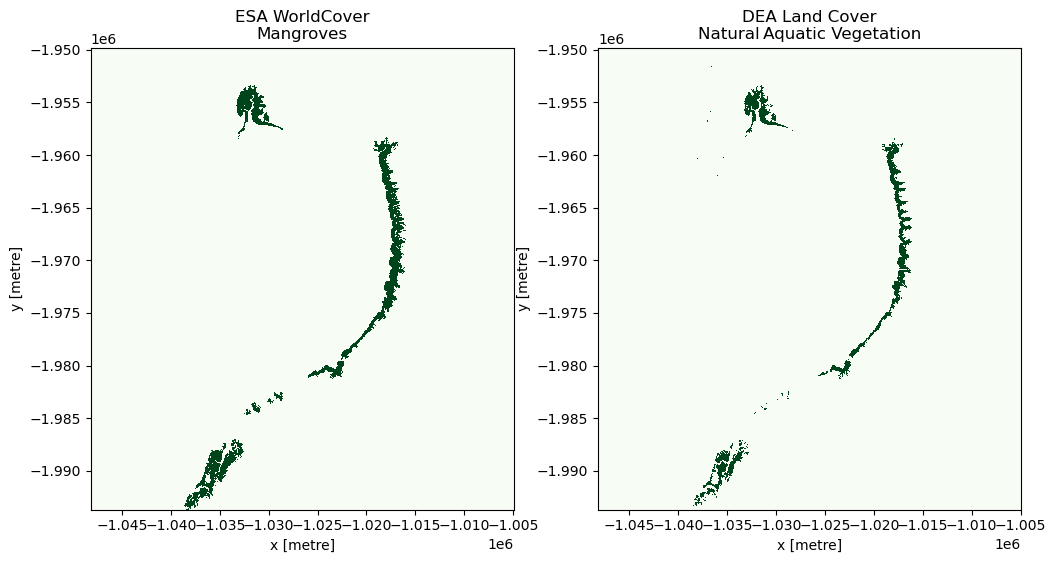

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Select classes and plot
(ds_worldcover["map"] == 95).plot(ax=axes[0], cmap="Greens", add_colorbar=False)
(ds_landcover["level3"] == 124).plot(ax=axes[1], cmap="Greens", add_colorbar=False)

# Add nicer titles
axes[0].set_title("ESA WorldCover\nMangroves")
axes[1].set_title("DEA Land Cover\nNatural Aquatic Vegetation");

In the plots above, mangrove vegetation is shown in green.
From these outputs, we can see that both products contain similar information about the distribution of mangroves at this study site.

## Load time series satellite data from Microsoft Planetary Computer

In the next example, we will show how to load surface temperature data from the **Landsat Collection 2 Level-2** satellite data product from Microsoft Planetary Computer:

> Landsat Collection 2 Level-2 Science Products, consisting of atmospherically corrected surface reflectance and surface temperature image data. Collection 2 Level-2 Science Products are available from August 22, 1982 to present. This dataset represents the global archive of Level-2 data from Landsat Collection 2 acquired by the Thematic Mapper onboard Landsat 4 and 5, the Enhanced Thematic Mapper onboard Landsat 7, and the Operatational Land Imager and Thermal Infrared Sensor onboard Landsat 8 and 9. Images are stored in cloud-optimized GeoTIFF format ([dataset listing](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#overview)).

First we search for data, using the product name **"landsat-c2-l2"**.

Unlike DEA's Landsat ARD, "landsat-c2-l2" combines all Landsat sensors into a single product. 
To select only Landsat 8 data, we need to specify this using a special STAC query syntax: `query={"platform": {"in": ["landsat-8"]}}`


In [11]:
# Convert data-cube style queries into something readable by `pystac_client`
bbox = BoundingBox.from_xy(x, y)
time_range = "/".join(time)

# Search for STAC items, filtering to Landsat 8 data only
search = catalog.search(
    collections="landsat-c2-l2",
    bbox=bbox,
    datetime=time_range,
    query={
        "platform": {"in": ["landsat-8"]},
    },
)

# Check how many items were returned
items = search.item_collection()
print(f"Found {len(items)} STAC items")

Found 14 STAC items


Now we load this data into our notebook using `odc.stac`, choosing to load only Landsat's surface temperature band **"lwir11"**:

In [12]:
# Load Landsat surface temperature data with ODC STAC
ds_usgs = odc.stac.load(
    items,
    bbox=bbox,
    bands=["lwir11"],
    crs="EPSG:3577",
    resolution=30,
    groupby="solar_day",
)

# Inspect outputs
ds_usgs

<xarray.Dataset>
Dimensions:      (y: 1464, x: 1441, time: 7)
Coordinates:
  * y            (y) float64 -1.95e+06 -1.95e+06 ... -1.994e+06 -1.994e+06
  * x            (x) float64 -1.048e+06 -1.048e+06 ... -1.005e+06 -1.005e+06
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2020-01-04T01:55:30.147982 ... 2020-02...
Data variables:
    lwir11       (time, y, x) uint16 27252 27640 28097 28458 28562 ... 0 0 0 0 0

Unlike DEA's ARD, USGS's Collection 2 Landsat surface temperature data [needs to be re-scaled to degrees Kelvin](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products#:~:text=Landsat%20Collection%202%20surface%20temperature,the%20scale%20factor%20is%20applied.) before we can use it:

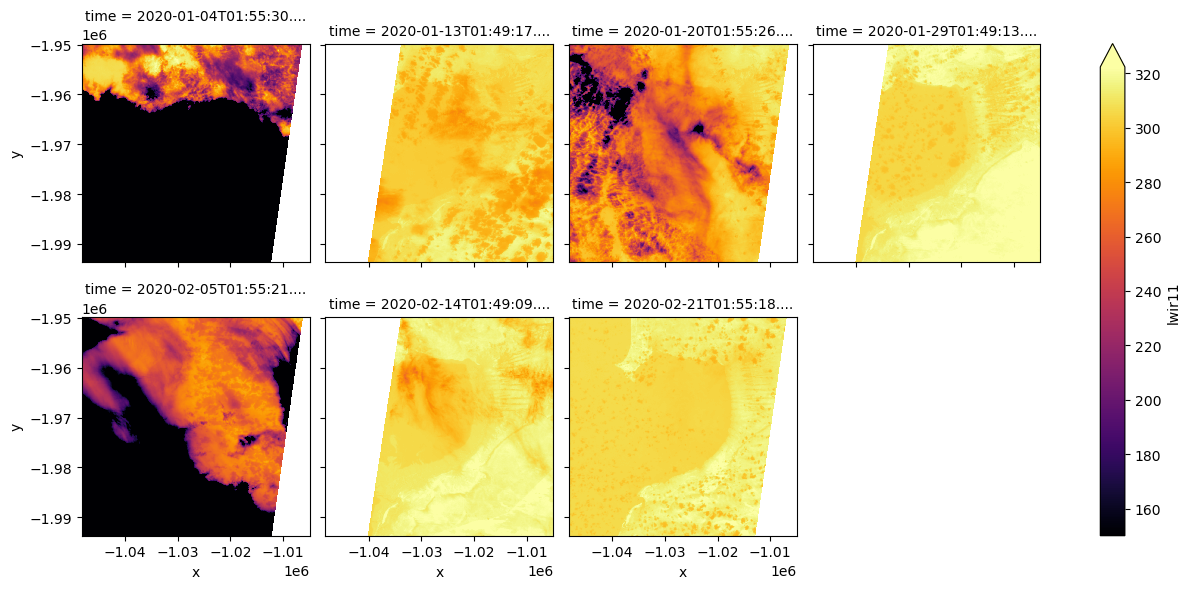

In [13]:
# First set 0 values to nodata
ds_usgs = ds_usgs.where(ds_usgs != 0)

# Apply USGS Collection 2 surface temperature scaling factors to obtain
# temperature in degrees Kelvin
ds_usgs = (ds_usgs * 0.00341802 + 149.0)

# Plot our temperature outputs
ds_usgs.lwir11.plot.imshow(col="time", col_wrap=4, cmap="inferno", robust=True)

### Load DEA Landsat data
Now we can load some Landsat 8 data for the same time and location from DEA:

In [14]:
ds_landsat = load_ard(
    dc=dc,
    products=["ga_ls8c_ard_3"],
    measurements=["nbart_red"],
    x=x,
    y=y,
    time=time,
    group_by="solar_day",
)

Finding datasets
    ga_ls8c_ard_3
Applying fmask pixel quality/cloud mask
Loading 7 time steps


Now we have loaded both products, we can insert our USGS Landsat surface temperature data as a new band in our dataset.
This allows us to perform analyses that require both Landsat surface reflectance and surface temperature data!

In [15]:
# Timesteps in both datasets differ by milliseconds, which prevents 
# xarray from automatically combining them. To work around this, first 
# use `.interp_like` to ensure times in both datasers are identical
ds_landsat["degrees_kelvin"] = ds_usgs.lwir11.interp_like(ds_landsat, method="nearest")
ds_landsat

<xarray.Dataset>
Dimensions:         (time: 7, y: 1464, x: 1441)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-04T01:55:30.109989 ... 2020...
  * y               (y) float64 -1.95e+06 -1.95e+06 ... -1.994e+06 -1.994e+06
  * x               (x) float64 -1.048e+06 -1.048e+06 ... -1.005e+06 -1.005e+06
    spatial_ref     int32 3577
Data variables:
    nbart_red       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    degrees_kelvin  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

We can also convert our temperature data from degrees Kelvin to degrees Celcius:

In [16]:
ds_landsat["degrees_celcius"] = ds_landsat.degrees_kelvin - 273.15
ds_landsat

<xarray.Dataset>
Dimensions:          (time: 7, y: 1464, x: 1441)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-04T01:55:30.109989 ... 202...
  * y                (y) float64 -1.95e+06 -1.95e+06 ... -1.994e+06 -1.994e+06
  * x                (x) float64 -1.048e+06 -1.048e+06 ... -1.005e+06 -1.005e+06
    spatial_ref      int32 3577
Data variables:
    nbart_red        (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    degrees_kelvin   (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    degrees_celcius  (time, y, x) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

If we plot Landsat surface temperature and imagery side-by-side, we can see areas of cool and hot terrain, including clouds that appear as dark cool pixels in the temperature data:

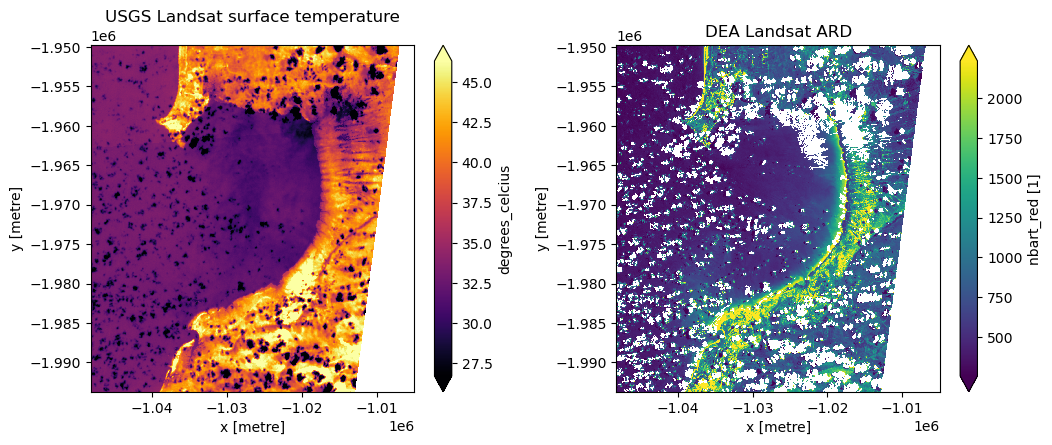

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
plt.subplots_adjust(wspace=0.3)

# Plot both DEA Landsat and USGS temperature data for a single timestep
timestep = ds_landsat.isel(time=6)
timestep.degrees_celcius.plot(ax=axes[0], cmap="inferno", robust=True)
timestep.nbart_red.plot(ax=axes[1], robust=True)

# Add nicer titles
axes[0].set_title("USGS Landsat surface temperature")
axes[1].set_title("DEA Landsat ARD");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [18]:
print(datacube.__version__)

1.8.13


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->